In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


This notebook contains KMeans clustering for mall customer segmentation. Please give me suggestions to improve this notebook :)

# Inspecting Dataset

In [2]:
df = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")

In [3]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


The data is already clean, we don't have to do further preprocessing

In [5]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Let's inspect the distribution of each features

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Gender', ylabel='count'>

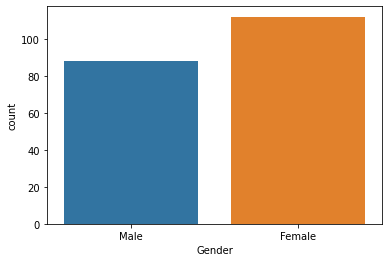

In [6]:
sns.countplot(df.Gender)

I think female might have higher spending score

In [7]:
print(df[df.Gender=="Female"]["Spending Score (1-100)"].mean())
print(df[df.Gender=="Male"]["Spending Score (1-100)"].mean())

51.526785714285715
48.51136363636363


well yes, but not that much

how about the distribution of other features?

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age'>

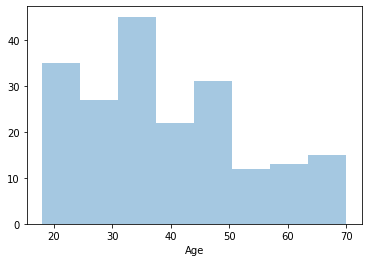

In [8]:
sns.distplot(df.Age, kde = False)

<AxesSubplot:xlabel='Annual Income (k$)'>

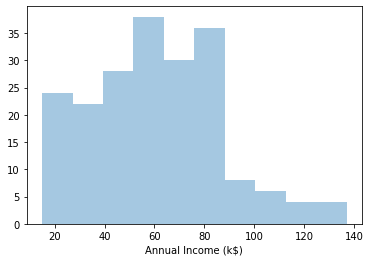

In [9]:
sns.distplot(df["Annual Income (k$)"], kde = False)

<AxesSubplot:xlabel='Spending Score (1-100)'>

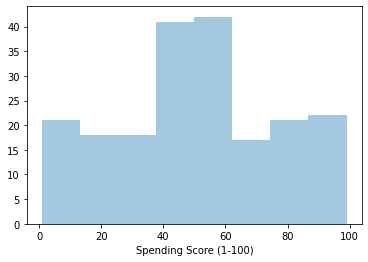

In [10]:
sns.distplot(df["Spending Score (1-100)"], kde = False)

ummm.. can't tell much,

let's plot spending score with annual income and age

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

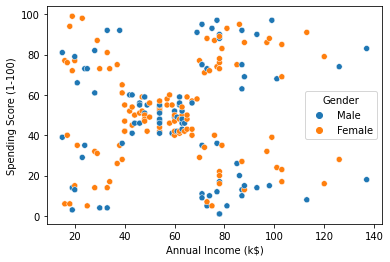

In [11]:
sns.scatterplot(x = df["Annual Income (k$)"], y =df["Spending Score (1-100)"], hue=df.Gender)

<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

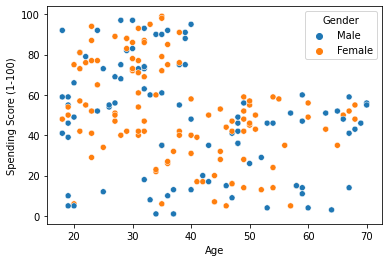

In [12]:
sns.scatterplot(x = df.Age, y =df["Spending Score (1-100)"], hue=df.Gender)

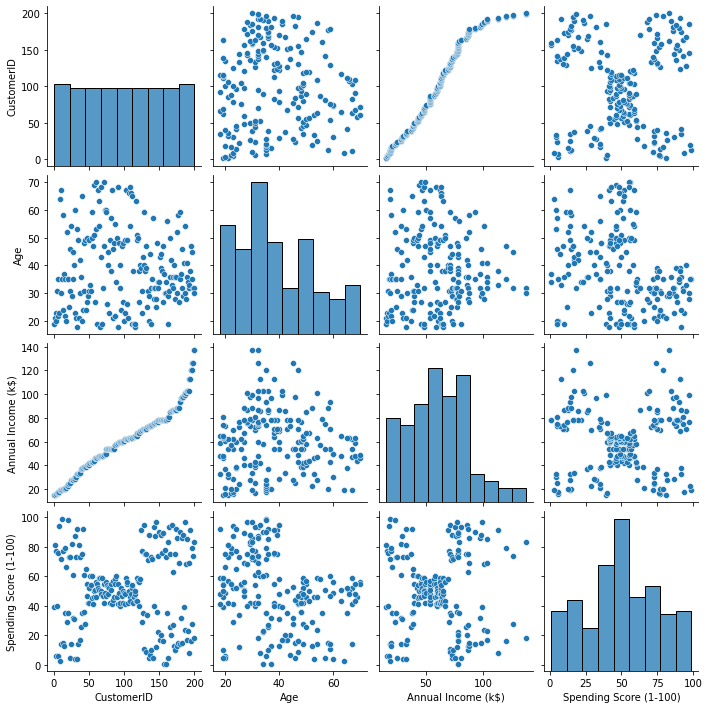

In [13]:
sns.pairplot(df)

It seems that we can do some clustering to divide the customer types, so we can focus on which customer to be the sales target.

# KMeans Clustering

I will divide clusters from two plot above, I will use elbow method to determine how many clusters I will use.

First, let's divide the customers based on their **income and spending**

In [14]:
income_spending = df.iloc[:,3:5]
income_spending

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


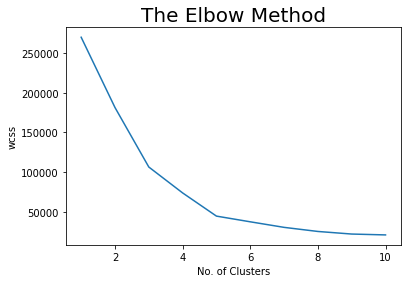

In [15]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(income_spending)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

It seems that five is the best number

In [16]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
income_spending["cluster"] = km.fit_predict(income_spending)
income_spending

,Annual Income (k$),Spending Score (1-100),cluster
0,15,39,4
1,15,81,3
2,16,6,4
3,16,77,3
4,17,40,4
...,...,...,...
195,120,79,2
196,126,28,0
197,126,74,2
198,137,18,0


Labelling clusters

In [17]:
cust_dict = {0:"target", 1:"usual", 2:"ideal", 3:"extravagant", 4:"possible"}
income_spending.cluster = income_spending["cluster"].map(cust_dict)

Plotting the clusters

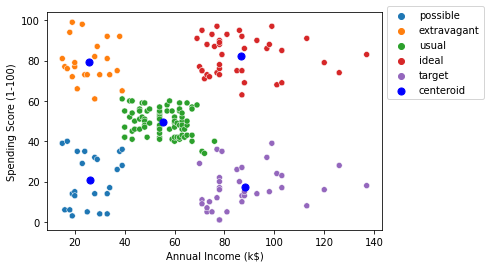

In [18]:
sns.scatterplot(x = "Annual Income (k$)", y = "Spending Score (1-100)", hue = "cluster", data = income_spending, palette="tab10")
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
plt.legend(bbox_to_anchor=(1, 1.05))

Now, I will divide the customers based on their Age and Spending

In [19]:
age_spending = df[["Age", "Spending Score (1-100)"]]

In [20]:
age_spending

,Age,Spending Score (1-100)
0,19,39
1,21,81
2,20,6
3,23,77
4,31,40
...,...,...
195,35,79
196,45,28
197,32,74
198,32,18


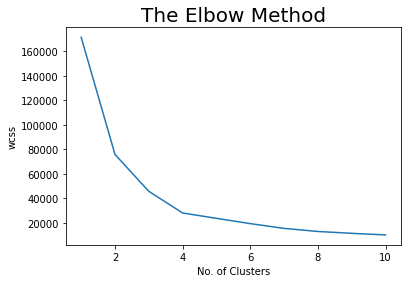

In [21]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(age_spending)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

Four is the best number

In [22]:
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)

age_spending["cluster"] =  km.fit_predict(age_spending)
cust_dict = {0:"target (young)", 1:"ideal", 2:"potential", 3:"target(old)"}
age_spending["cluster"] = age_spending["cluster"].map(cust_dict)

age_spending

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Age,Spending Score (1-100),cluster
0,19,39,potential
1,21,81,ideal
2,20,6,target (young)
3,23,77,ideal
4,31,40,potential
...,...,...,...
195,35,79,ideal
196,45,28,target (young)
197,32,74,ideal
198,32,18,target (young)


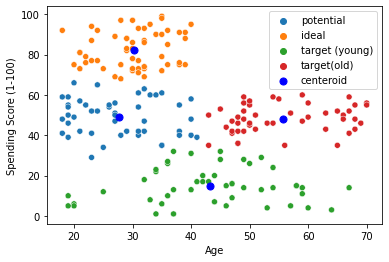

In [23]:
sns.scatterplot(x="Age", y="Spending Score (1-100)", hue="cluster", data=age_spending, palette="tab10")
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
plt.legend(bbox_to_anchor=(1, 1))

How about combining all features?

In [24]:
df3d = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]

In [25]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
df3d["cluster"] = km.fit_predict(df3d)
cust_dict = {0:"ideal", 1:"possible", 2:"usual", 3:"extravagant", 4:"target"}
df3d.cluster = df3d.cluster.map(cust_dict)
df3d

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Age,Annual Income (k$),Spending Score (1-100),cluster
0,19,15,39,ideal
1,21,15,81,target
2,20,16,6,ideal
3,23,16,77,target
4,31,17,40,ideal
...,...,...,...,...
195,35,120,79,possible
196,45,126,28,extravagant
197,32,126,74,possible
198,32,137,18,extravagant


In [26]:
import plotly.graph_objs as go

In [27]:
import plotly.express as px

fig = px.scatter_3d(df3d, x="Annual Income (k$)", y="Spending Score (1-100)", z="Age",
                    color='cluster', title="Mall Customer Segmentation")

fig.show()

**That's it!**, please give me your suggestions to improve this notebook :)